# Notebook for training NN to reconstruct energy

In [31]:
import torch
import numpy as np
import pandas as pd
import uproot as up
from reco import process_data_energy_reco,Predictor,train,plot_predictions,evaluate_model,shuffle_segment_data,plot_loss_predictions
from IPython.display import clear_output
import matplotlib.pyplot as plot
from numba import jit
from tqdm import tqdm

In [2]:
# Get device to be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
from util import get_layer, create_layer_map
layer_map,super_layer_map = create_layer_map()
def get_p(px,py,pz):
    sq = pow(px,2) + pow(py,2) + pow(pz,2)
    return pow(sq,0.5)
def calculate_num_pixels_z_dependence(energy_dep, z_hit):
    efficiency = inverse(770 - z_hit, 494.98, 9.9733, -0.16796)
    return 10 * energy_dep * (1000 * 1000) * efficiency / 100
def inverse(x, a, b, c):
    return a / (x + b) + c
def process_data_energy_reco(uproot_path,samples_path, file_num=0, particle="pion"):
    num_layers = 28
    
    events = up.open(uproot_path)
    sampled_times = torch.load(samples_path + "samples.pt")
    event_idxs = torch.load(samples_path + "events.pt")
    layer_idxs = torch.load(samples_path + "layers.pt")
    
    x_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.x"].array(library='np')
    z_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.z"].array(library='np')
    EDep_branch = events["HcalBarrelHits.EDep"].array(library='np')
    PDG_branch = events["MCParticles.PDG"].array(library='np')
    mc_px = events["MCParticles.momentum.x"].array(library='np')
    mc_py = events["MCParticles.momentum.y"].array(library='np')
    mc_pz = events["MCParticles.momentum.z"].array(library='np')
    x_momentum_branch = events["HcalBarrelHits/HcalBarrelHits.momentum.x"].array(library='np')
    y_momentum_branch = events["HcalBarrelHits/HcalBarrelHits.momentum.y"].array(library='np')
    z_momentum_branch = events["HcalBarrelHits/HcalBarrelHits.momentum.z"].array(library='np')
    Hits_MC_idx_branch = events["_HcalBarrelHits_MCParticle.index"].array(library='np')
    time_branch = events["HcalBarrelHits.time"].array(library='np')   
    num_events = len(x_pos_branch)
    data = torch.ones(num_events,10 * num_layers + 1) * -999
    for event_idx in range(num_events):
        clear_output(wait=True)
        print(f"Event #{event_idx}")
        
        
        primary_momentum = get_p(mc_px[event_idx][0],mc_py[event_idx][0],mc_pz[event_idx][0])
        
        Hits_MC_idx_event = Hits_MC_idx_branch[event_idx]
        PDG_event = PDG_branch[event_idx]
        
        z_hit_layer_list = np.ones((num_layers)) * -999
        edep_event = np.ones((num_layers)) * -999
        
        x_pos_event = x_pos_branch[event_idx]
        z_event = z_pos_branch[event_idx]
        EDep_event = EDep_branch[event_idx]
        
        time_event = time_branch[event_idx]
        event_layer_first_times = np.ones(28) * 9999
        event_layer_all_times = [[] for i in range(28)]
        for hit_idx in range(len(x_pos_event)):
            idx = Hits_MC_idx_branch[event_idx][hit_idx]
            layer_idx = get_layer(x_pos_event[hit_idx], super_layer_map)
            if layer_idx == -1: #error handling for get_layer
                continue
            event_layer_all_times[layer_idx].append(time_event[hit_idx])
            if edep_event[layer_idx] == -999:
                z_hit_layer_list[layer_idx] = z_event[hit_idx]
                edep_event[layer_idx] = EDep_event[hit_idx]
            else:
                edep_event[layer_idx] += EDep_event[hit_idx]
        for i in range(28):
            if(len(event_layer_all_times[i])):
                event_layer_sampled_times = sampled_times[(event_idxs == event_idx) & (layer_idxs == i)]
                if(len(event_layer_sampled_times) > 10):
                    k = 10
                elif(len(event_layer_sampled_times) == 0):
                    continue
                else:
                    k = len(event_layer_sampled_times)
                data[event_idx][i * 10:((i * 10)+k)] = torch.topk(event_layer_sampled_times, k=k, largest=False)[0]
        data[event_idx][280] = torch.tensor(primary_momentum)
    data[data < 0] = 0
    return data 

In [32]:


@jit(nopython=True)
def get_p(px, py, pz):
    return np.sqrt(px**2 + py**2 + pz**2)

@jit(nopython=True)
def calculate_num_pixels_z_dependence(energy_dep, z_hit):
    efficiency = inverse(770 - z_hit, 494.98, 9.9733, -0.16796)
    return 10 * energy_dep * (1000 * 1000) * efficiency / 100

@jit(nopython=True)
def inverse(x, a, b, c):
    return a / (x + b) + c

def process_data_energy_reco(uproot_path, samples_path, file_num=0, particle="pion"):
    num_layers = 28
    
    events = up.open(uproot_path)
    sampled_times = torch.load(samples_path + "samples.pt")
    event_idxs = torch.load(samples_path + "events.pt")
    layer_idxs = torch.load(samples_path + "layers.pt")
    
    x_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.x"].array(library='np')
    z_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.z"].array(library='np')
    EDep_branch = events["HcalBarrelHits.EDep"].array(library='np')
    mc_px = events["MCParticles.momentum.x"].array(library='np')
    mc_py = events["MCParticles.momentum.y"].array(library='np')
    mc_pz = events["MCParticles.momentum.z"].array(library='np')
    Hits_MC_idx_branch = events["_HcalBarrelHits_MCParticle.index"].array(library='np')
    time_branch = events["HcalBarrelHits.time"].array(library='np')   
    
    num_events = len(x_pos_branch)
    data = torch.full((num_events, 10 * num_layers + 1), -999.0)
    
    for event_idx in tqdm(range(num_events), desc="Processing events"):
        primary_momentum = get_p(mc_px[event_idx][0], mc_py[event_idx][0], mc_pz[event_idx][0])
        
        z_hit_layer_list = np.full(num_layers, -999.0)
        edep_event = np.full(num_layers, -999.0)
        
        x_pos_event = x_pos_branch[event_idx]
        z_event = z_pos_branch[event_idx]
        EDep_event = EDep_branch[event_idx]
        time_event = time_branch[event_idx]
        
        event_layer_all_times = [[] for _ in range(num_layers)]
        
        for hit_idx, (x_pos, z_pos, edep, time) in enumerate(zip(x_pos_event, z_event, EDep_event, time_event)):
            layer_idx = get_layer(x_pos, super_layer_map)
            if layer_idx == -1:
                continue
            event_layer_all_times[layer_idx].append(time)
            if edep_event[layer_idx] == -999:
                z_hit_layer_list[layer_idx] = z_pos
                edep_event[layer_idx] = edep
            else:
                edep_event[layer_idx] += edep
        
        event_mask = event_idxs == event_idx
        for i in range(num_layers):
            layer_mask = layer_idxs == i
            event_layer_sampled_times = sampled_times[event_mask & layer_mask]
            k = min(len(event_layer_sampled_times), 10)
            if k > 0:
                data[event_idx, i*10:i*10+k] = torch.topk(event_layer_sampled_times, k=k, largest=False)[0]
        
        data[event_idx, -1] = primary_momentum
    
    data = data.clamp(min=0)
    return data

# Assuming these are defined elsewhere in your code
from util import get_layer, create_layer_map
layer_map, super_layer_map = create_layer_map()

In [33]:
in_dim = 28
out_dim = 1
num_epochs = 1
batch_size = 100
samples_path = "data/samples/August_29/August_28_mu_5k_"
data_path = "/hpc/group/vossenlab/rck32/eic/work_eic/root_files/August_28/sector_scint/run_1/run_1_n_0_8_10GeV_theta_90_5kevents.edm4hep.root:events"
# data_path = "/hpc/group/vossenlab/rck32/eic/work_eic/root_files/August_28/sector_scint/run_1_n_0_8_10GeV_theta_90_500kevents.edm4hep.root:events"
inputs = process_data_energy_reco(data_path,samples_path)

/tmp/ipykernel_3424494/2649549750.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sampled_times = torch.load(samples_path + "samples.pt")
/tmp/ipykernel_3424494/2649549

KeyboardInterrupt: 

In [23]:
train_data, test_data, val_data = shuffle_segment_data(inputs)

Event #999


In [24]:
model = Predictor(input_size=56, num_classes=1, hidden_dim = 512, num_layers = 20)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

In [25]:
loss_hist = train(model, train_data,optimizer,device, num_epochs = 4, batch_size = 50, show_progress = True)

Training epoch #3


100%|██████████| 16/16 [00:00<00:00, 232.34it/s]

Finished Training


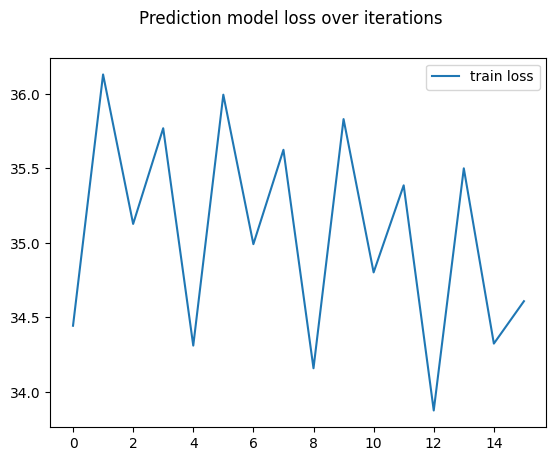

In [26]:
plot_loss_predictions(loss_hist)

In [ ]:
len(test_data)

Mean Absolute Error: 5.7958
Mean Squared Error: 40.8939
Root Mean Squared Error: 6.3948
R-squared Score: -4.6928


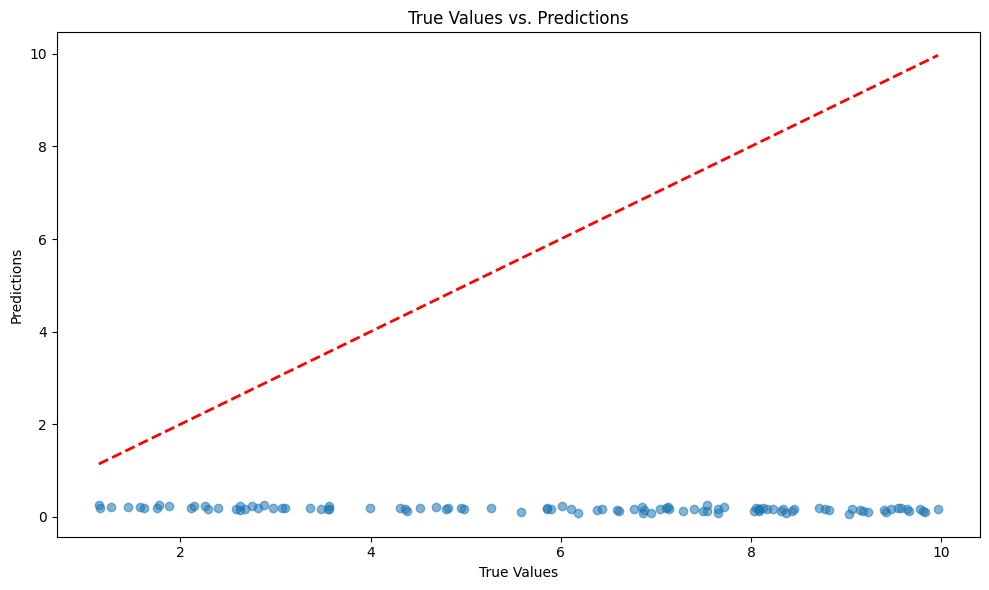

In [27]:
mae, mse, rmse, r2 = evaluate_model(model, test_data, device)